In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import csv
import tifffile  # to load tiff files efficiently
import cv2 # Open-CV for selecting a ROI
import itertools #to flatten a list of list
import datetime
from datetime import datetime as dt
from datetime import time

from scipy.optimize import curve_fit

# image results should be stored in the same directory as the hdf5 file associated with the experiment
results = "..\\artiq_results" 

# origin's timestamps are in unix time times 2**32 and there seems to be
# a five hour offset. two years ago I observed a 6 hour offset, but they may
# have been a daylight savings time difference. also this issue doesn't arise
# when grabbing the data with the origin reader
origintime_to_dt = lambda x: dt.utcfromtimestamp(x/2**32 - 5*3600).strftime(
    '%m-%d %H:%M')

# consts
kB = 1.38e-23
mRb = 1.44316060e-25
ms = 1e-3

## 2023.10.10

In [8]:
datestr = "2023-10-09"

### estimate microns/pixel with known dimensions

In [333]:
xtifstack = np.array(list(itertools.chain(*[tifffile.imread(os.path.join(results,datestr,"17\\MOT_Xshim_scan.tif"))
    for f in filenames
]))) # flattening tifstackList

In [204]:
xtifstack.shape

(650, 1002, 1004)

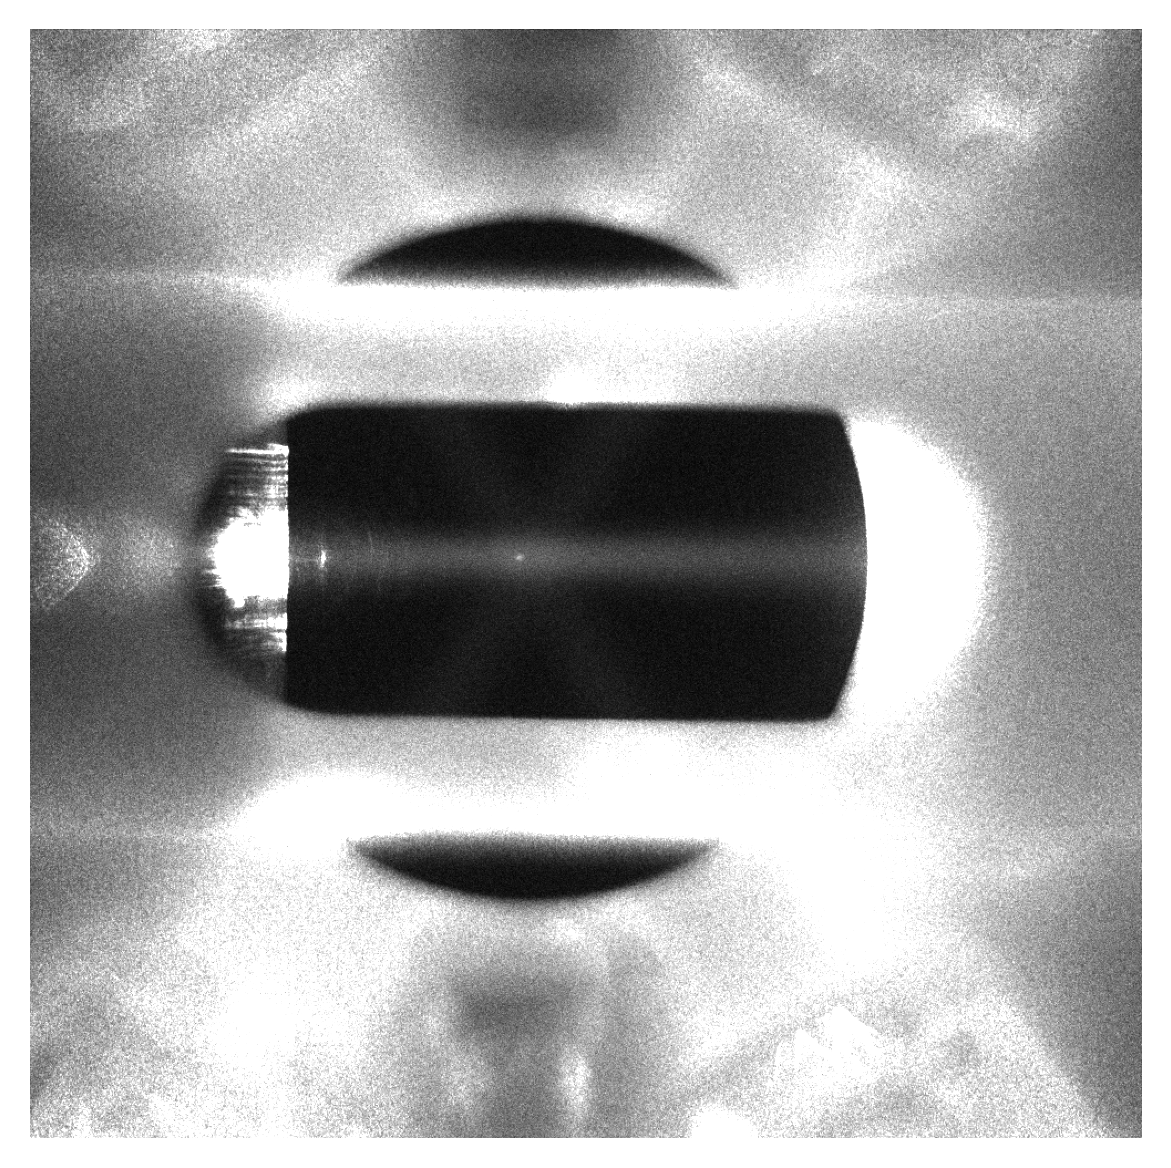

In [366]:
fig,ax = plt.subplots(dpi=300)
cax=ax.imshow(xtifstack[0],cmap='grey',vmin=800,vmax=7500)
ax.set_axis_off()
plt.savefig('MOT_showing_chip_optics_20231009.pdf',bbox_inches='tight',pad_inches=0)
# fig.colorbar(cax)

In [342]:
os.getcwd()

'D:\\Networking Exp Data\\MOT sensitivity to B fields'

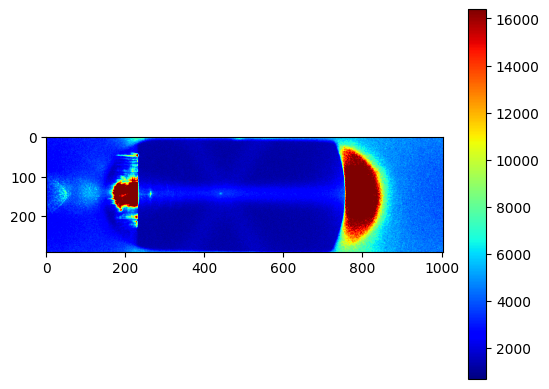

In [205]:
plt.imshow(xtifstack[0][335:625],cmap='jet')#,vmin=500,vmax=1000)
plt.colorbar()

In [206]:
pixels_per_um = -(335-625)/5600 # the slot width is 5.6 mm
pixels_per_um, 1/pixels_per_um

(0.05178571428571429, 19.310344827586206)

In [207]:
ppm = lambda pixels: 1e-6*pixels/pixels_per_um # pixels per meter, not parts per million

### X Shim scan data
x shim scan data imported in previous cell block

In [285]:
f = h5py.File(os.path.join(results, datestr, '17\\000006200-CoilScanSPCMCount1D.h5'))
x_shimsteps = eval(np.bytes_(f['datasets']['coil_V_array']))
iterations = np.intc(f['datasets']['iterations'])

steps = len(x_shimsteps)

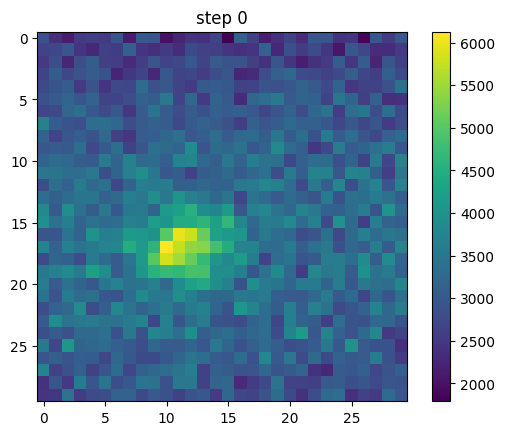

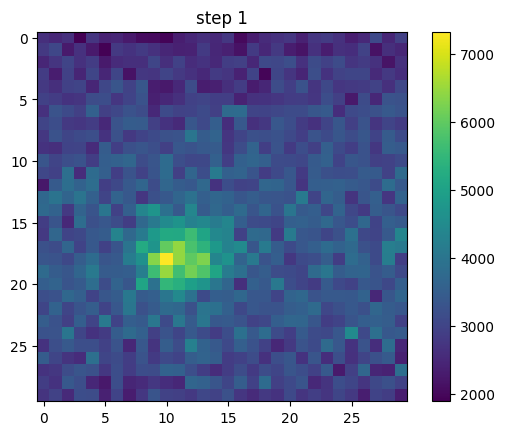

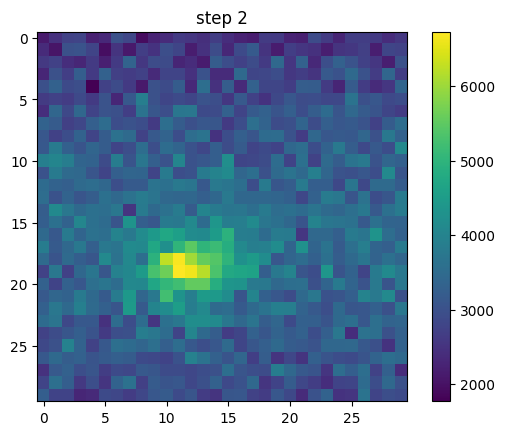

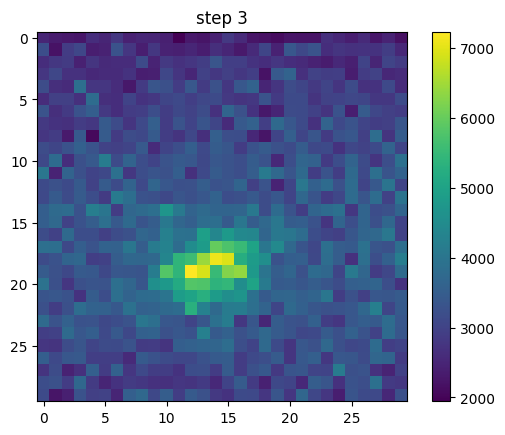

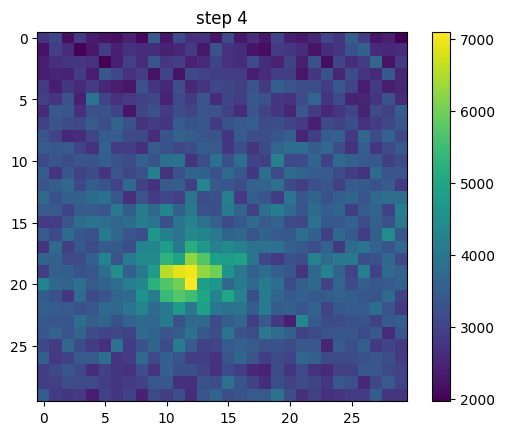

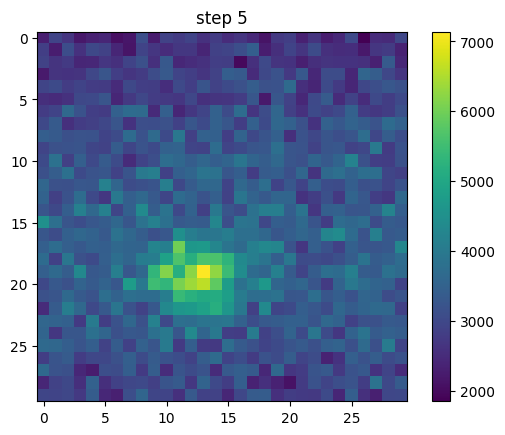

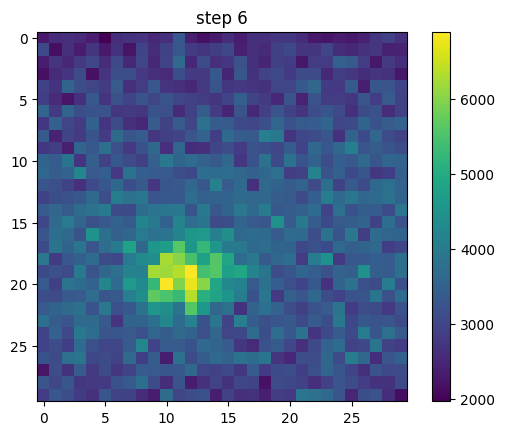

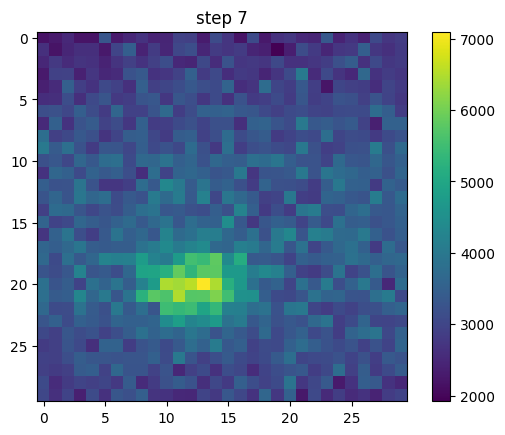

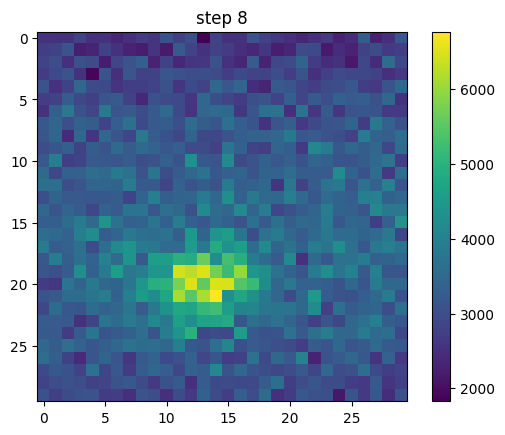

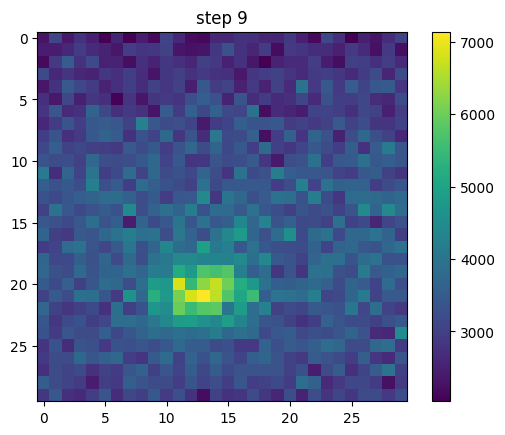

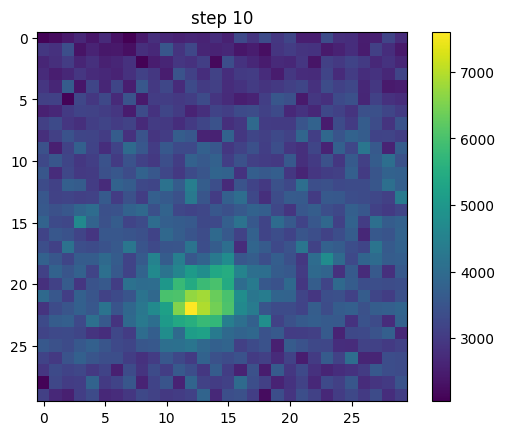

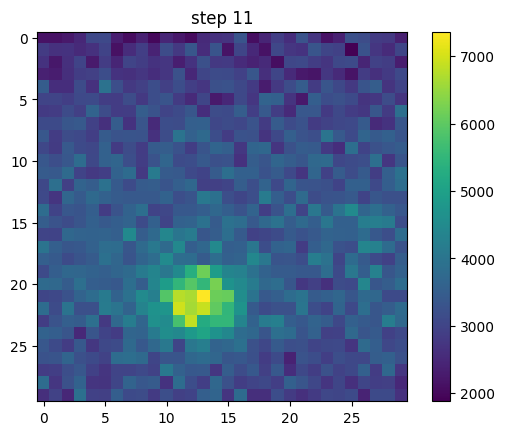

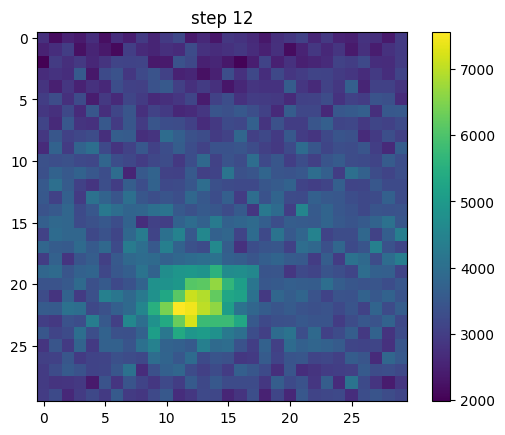

In [222]:
for i in range(steps):
    plt.imshow(xtifstack[i][460:490,430:460])
    plt.title(f'step {i}')
    plt.colorbar()
    plt.show()

In [214]:
xtifstack.shape

(650, 1002, 1004)

there may have been drift of the MOT over the 100 iterations, which took about 12 minutes,
so break up the data into 10 groups

In [323]:
images = xtifstack[:,460:490,430:460]
groups = 10
averages = int(iterations/groups)
assert iterations%groups == 0
image_groups = []
for i in range(groups):
    im_group = images[i*steps*averages:(i+1)*steps*averages,:,:]
    images_by_step = im_group.reshape(-1,steps,*im_group.shape[1:])
    image_groups.append(images_by_step)

In [324]:
images_by_step.shape

(5, 13, 30, 30)

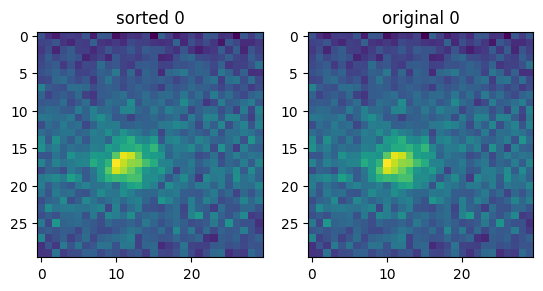

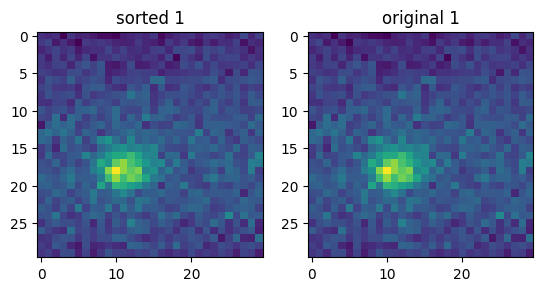

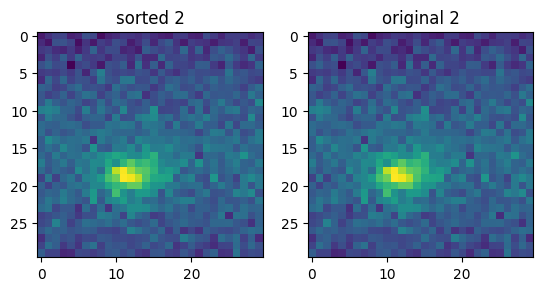

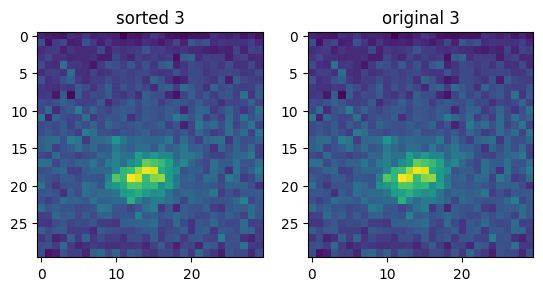

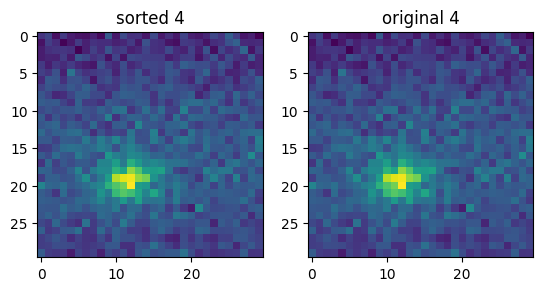

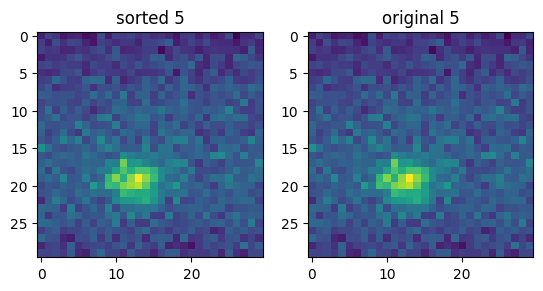

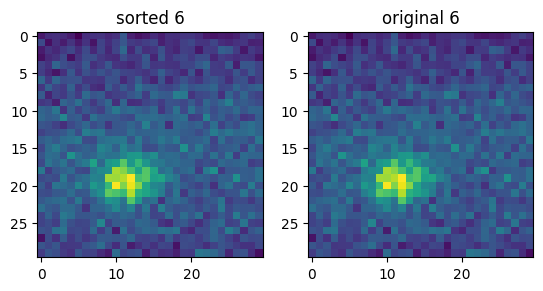

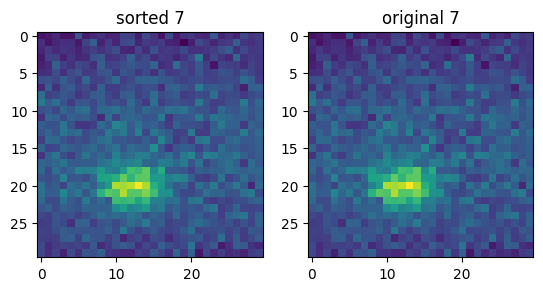

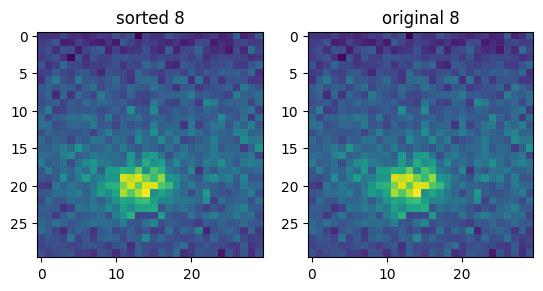

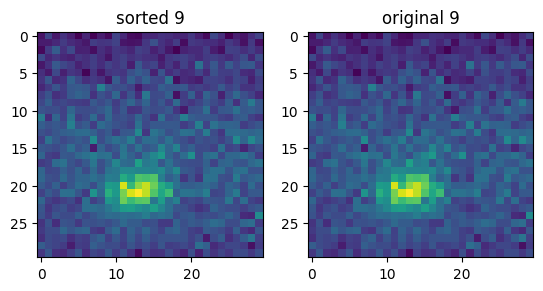

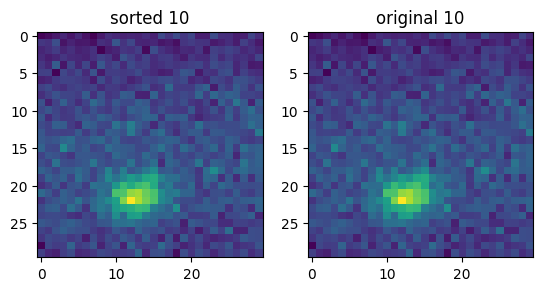

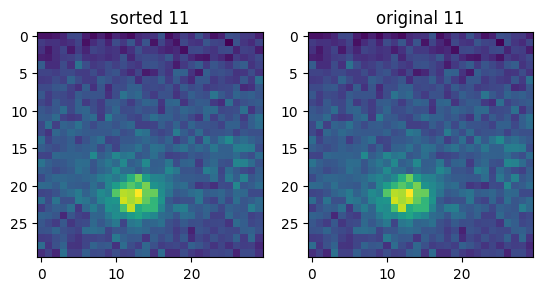

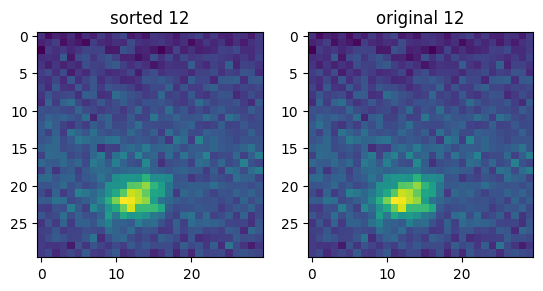

In [325]:
# check that we understand how the data was sorted
for i in range(steps):
    fig,(ax,ax2) = plt.subplots(ncols=2)
    ax.imshow(image_groups[0][0][i]) # zeroth index is group, first is iteration, second is step
    ax.set_title(f"sorted {i}")
    ax2.imshow(images[i,:,:])
    ax2.set_title(f"original {i}")
    plt.show()

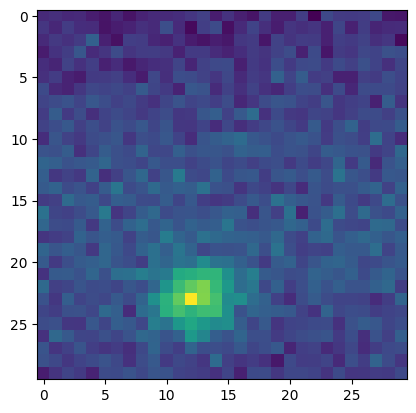

In [326]:
plt.imshow(image_groups[9][4,12]) # last group, last iteration in that group, and last step of the 13-point scan

In [327]:
mean_im_groups = [] # stores groups each containing steps number of images averaged over iterations/groups number of iterations
for i in range(groups):
    mean_ims_by_step = [np.mean(image_groups[i][:,j],axis=0) for j in range(steps)]
    mean_im_groups.append(mean_ims_by_step)

In [328]:
len(mean_im_groups[0])

13

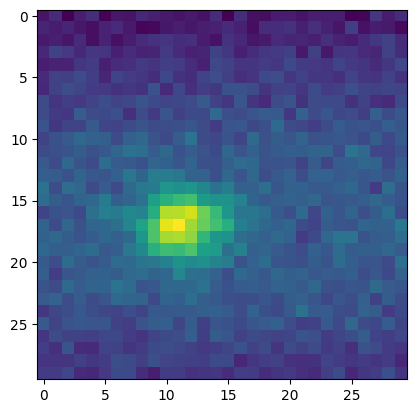

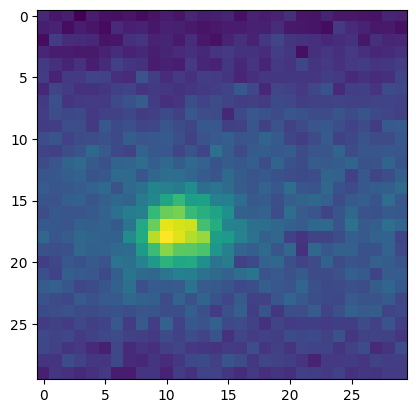

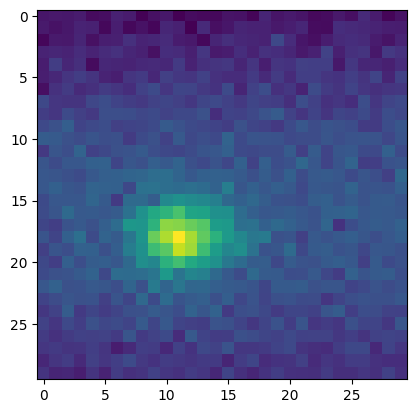

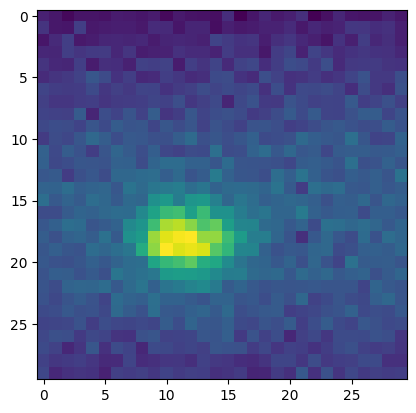

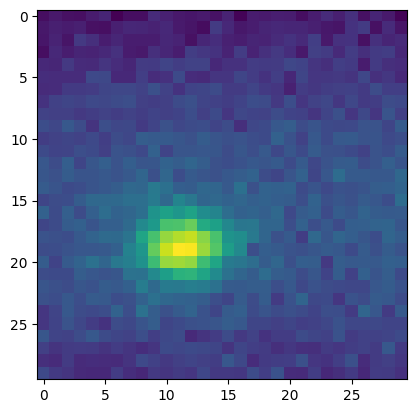

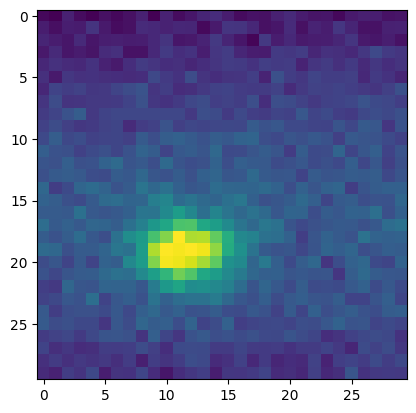

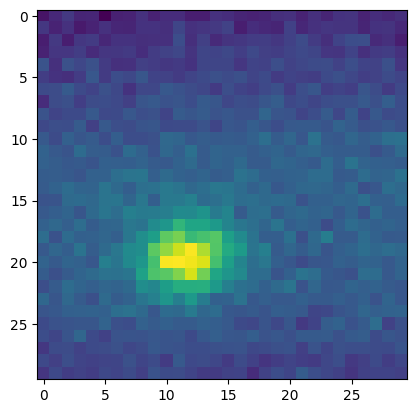

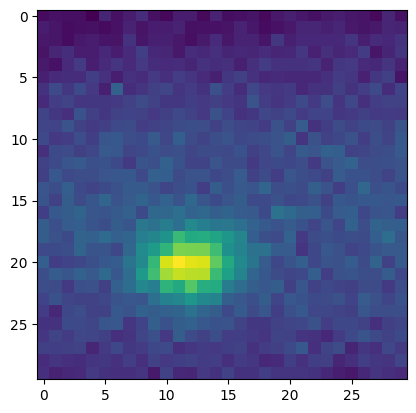

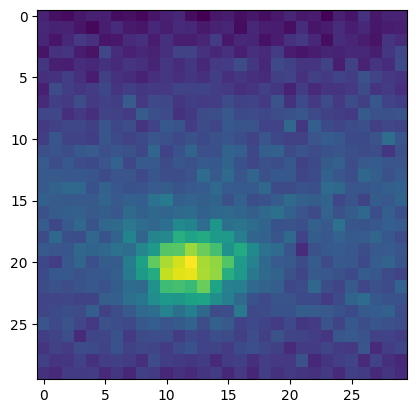

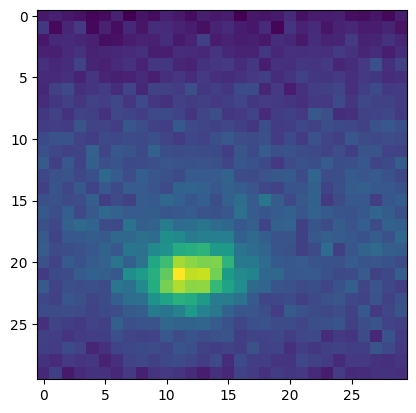

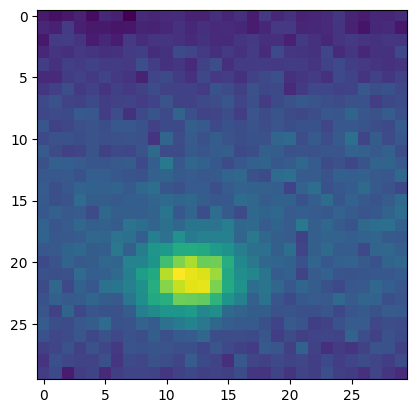

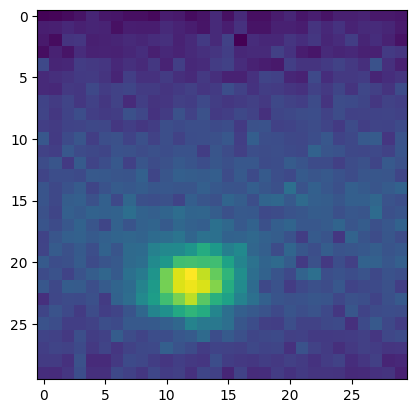

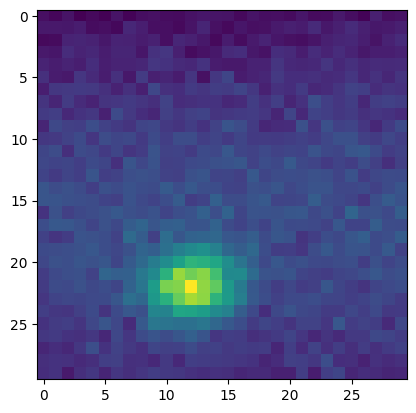

In [329]:
for im in mean_im_groups[0]:
    plt.imshow(im)
    plt.show()

In [330]:
showplots = False

def model(x, x0, w0, b):
            return np.exp(-2*((x-x0)/w0)**2) + b

x_groups = [] # store arrays of the x positions of the MOT for each group of averaged images
y_groups = [] # store arrays of the y positions of the MOT for each group of averaged images

for group in mean_im_groups:

    x_arr = np.zeros(steps)
    y_arr = np.zeros(steps)

    for i,im in enumerate(group):
        # generate projections, fits, etc

        bg = np.mean([im[12:17,25:30] for i in range(steps)])

        image = im
        image[image < bg] = bg
        image -= bg
        
        xproj = np.sum(image,axis=0)
        xproj /= max(xproj)
        yproj = np.sum(image,axis=1)
        yproj /= max(yproj)

        # mean, waist, offset
        x_guess = [12,5,0]
        y_guess = [19,4,0]
        upper_bounds = [30,20,1.1]
        lower_bounds = [0,3,-0.1]

        xpts = np.arange(im.shape[1])
        ypts = np.arange(im.shape[0])

        xparams, _ = curve_fit(model, xpts, xproj, p0=x_guess, 
                           bounds=[lower_bounds,upper_bounds])
            
        yparams, _ = curve_fit(model, ypts, yproj, p0=y_guess, 
                           bounds=[lower_bounds,upper_bounds])

        x_arr[i] = xparams[0]
        y_arr[i] = yparams[0]

        if showplots:
            plt.imshow(image)
            plt.title(f"image{i}")
            plt.show()
            plt.plot(xproj)
            plt.plot(model(xpts,*xparams))
            plt.plot(yproj)
            plt.plot(model(ypts,*yparams))
            plt.show()
    x_groups.append(x_arr)
    y_groups.append(y_arr)

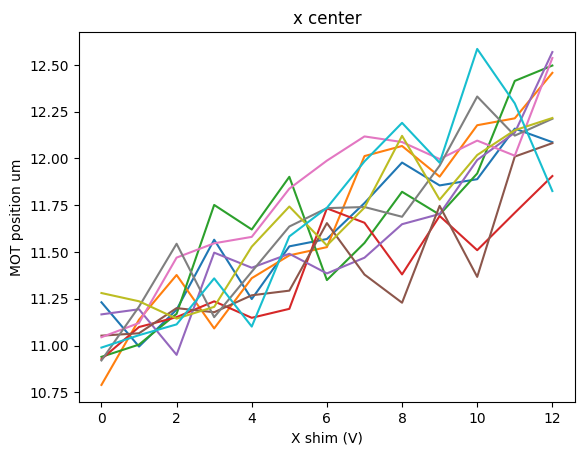

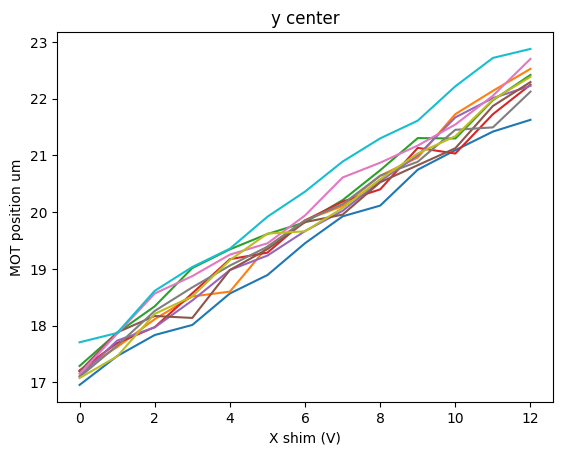

In [331]:
# each of the curves below is itself an average over 10 iterations as defined in the experiment (i.e. the 13 step sequence)
fig,ax = plt.subplots()
for x in x_groups:
    plt.plot(x) #,label='x center')
ax.set_ylabel('MOT position um')
ax.set_xlabel('X shim (V)')
ax.set_title('x center')
plt.show()

fig,ax = plt.subplots()
for y in y_groups:
    plt.plot(y)
ax.set_ylabel('MOT position um')
ax.set_xlabel('X shim (V)')
ax.set_title('y center')
plt.show()

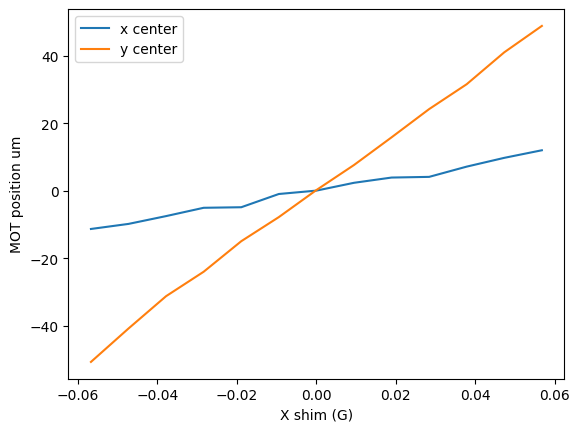

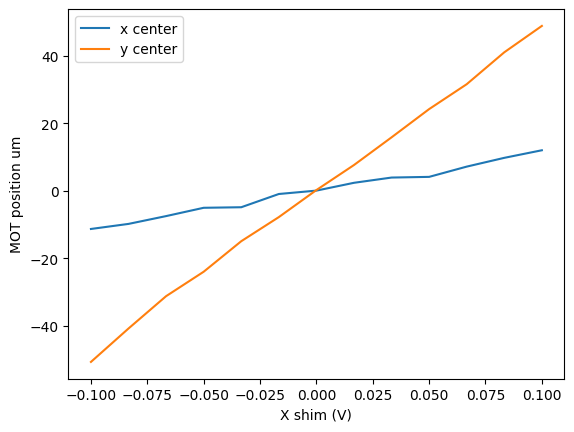

In [332]:
# average the curves for each group, but subtract the means first

x_means = np.mean([x-np.mean(x) for x in x_groups],axis=0)
y_means = np.mean([y-np.mean(y) for y in y_groups],axis=0)

Bpts = x_shimsteps*0.25*2.27 # (Zotino V)*(coil driver A/V)*(measured coil G/A)

fig,ax = plt.subplots()
ax.plot(Bpts,x_means/pixels_per_um,label='x center')
ax.plot(Bpts,y_means/pixels_per_um,label='y center')
ax.set_ylabel('MOT position um')
ax.set_xlabel('X shim (G)')
ax.legend()
plt.show()

fig,ax = plt.subplots()
ax.plot(x_shimsteps,x_means/pixels_per_um,label='x center')
ax.plot(x_shimsteps,y_means/pixels_per_um,label='y center')
ax.set_ylabel('MOT position um')
ax.set_xlabel('X shim (V)')
ax.legend()
plt.show()

# for x,y in zip(x_groups,y_groups):
#     plt.plot(x-np.mean(x),label='x center')
#     plt.plot(y-np.mean(y),label='y center')
#     plt.legend()
#     plt.show()

In [293]:
print("microns per mG",80/100)
print("microns per mV",100/200)

microns per mG 0.8
microns per mV 0.5


## Y shim scan data

In [295]:
ytifstack = np.array(list(itertools.chain(*[tifffile.imread(os.path.join(results,datestr,"17\\MOT_Yshim_scan.tif"))
    for f in filenames
]))) # flattening tifstackList

In [297]:
f = h5py.File(os.path.join(results, datestr, '17\\000006201-CoilScanSPCMCount1D.h5'))
y_shimsteps = eval(np.bytes_(f['datasets']['coil_V_array']))
iterations = np.intc(f['datasets']['iterations'])

steps = len(y_shimsteps)

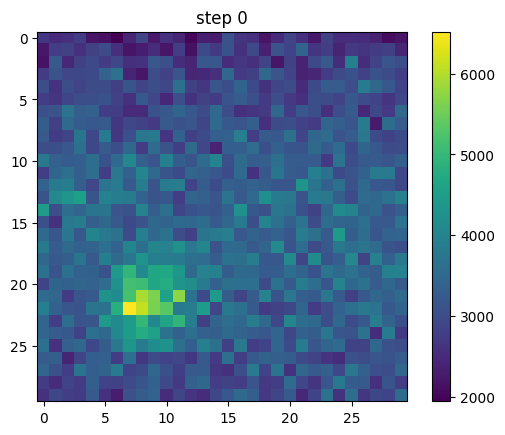

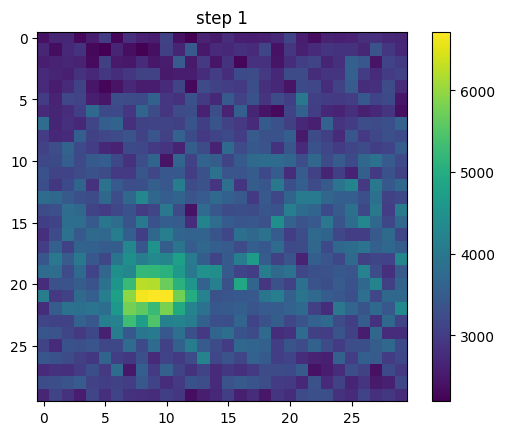

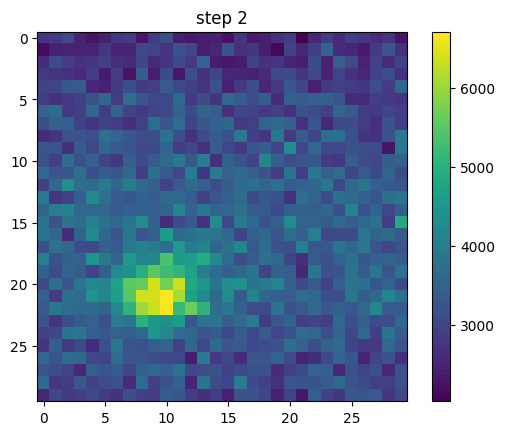

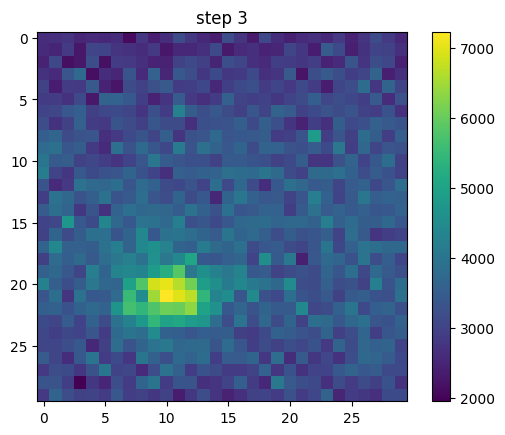

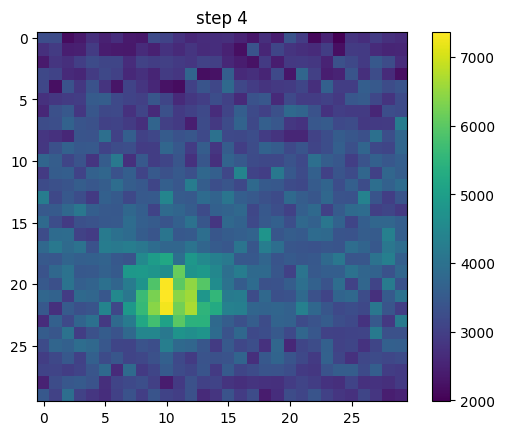

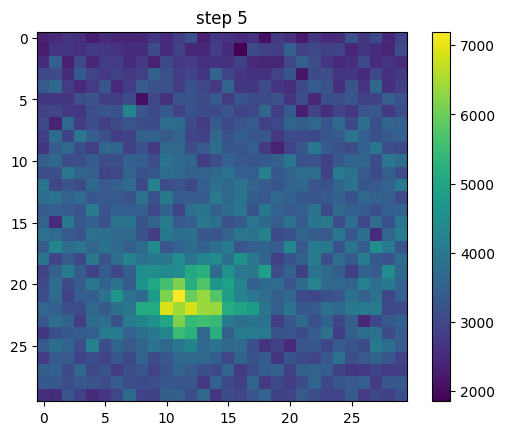

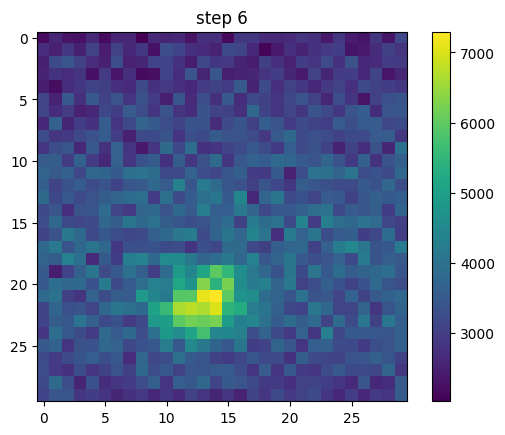

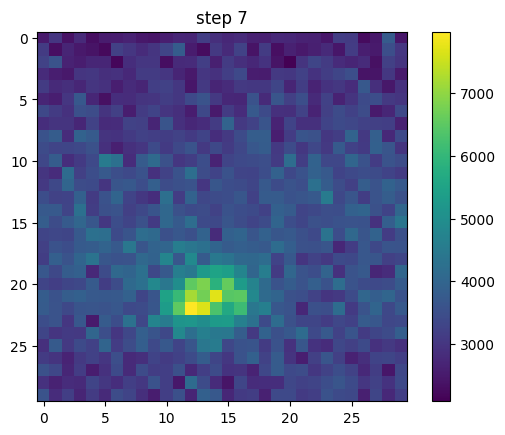

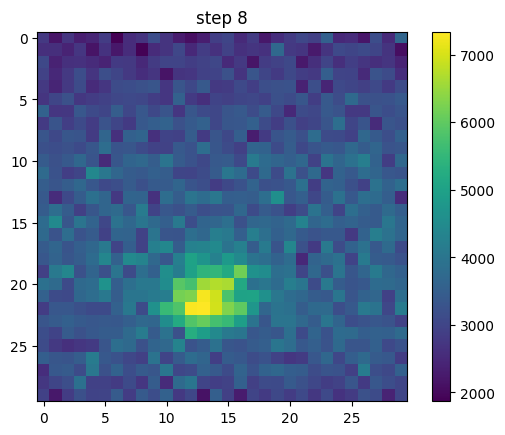

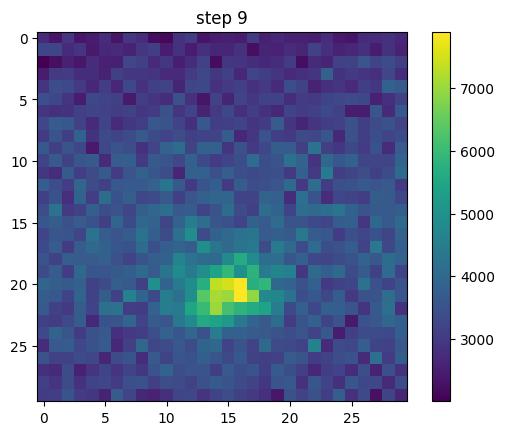

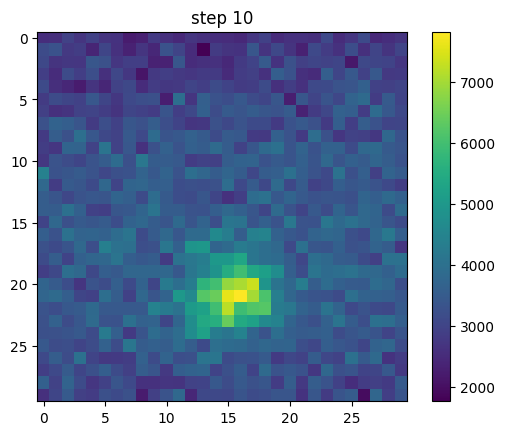

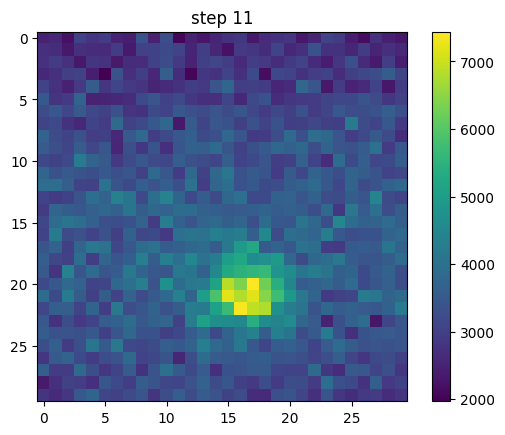

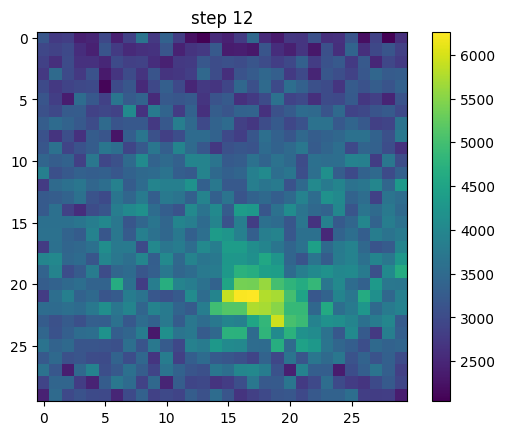

In [298]:
for i in range(steps):
    plt.imshow(ytifstack[i][460:490,430:460])
    plt.title(f'step {i}')
    plt.colorbar()
    plt.show()

In [214]:
ytifstack.shape

(650, 1002, 1004)

there may have been drift of the MOT over the 100 iterations, which took about 12 minutes,
so break up the data into 10 groups

In [313]:
images = ytifstack[:,460:490,430:460]
groups = 10
averages = int(iterations/groups)
assert iterations%groups == 0
image_groups = []
for i in range(groups):
    im_group = images[i*steps*averages:(i+1)*steps*averages,:,:]
    images_by_step = im_group.reshape(-1,steps,*im_group.shape[1:])
    image_groups.append(images_by_step)

In [314]:
images_by_step.shape

(5, 13, 30, 30)

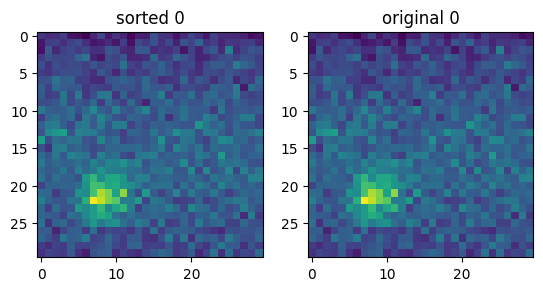

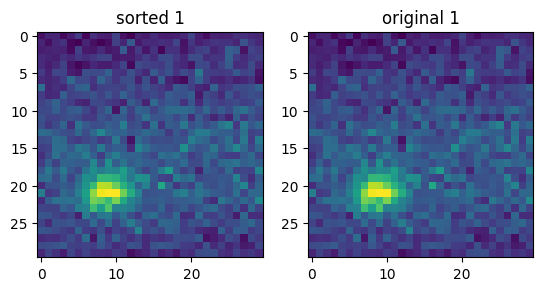

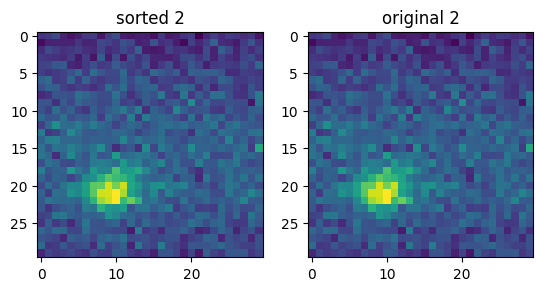

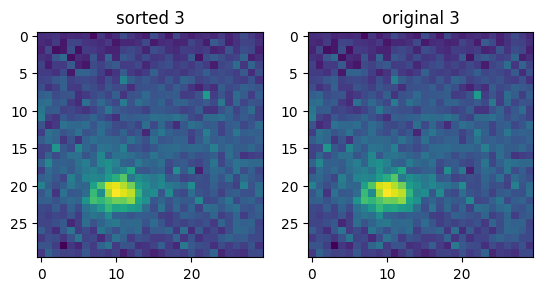

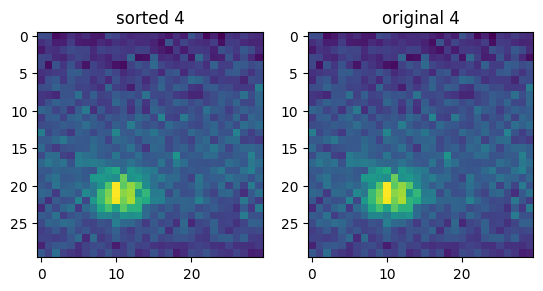

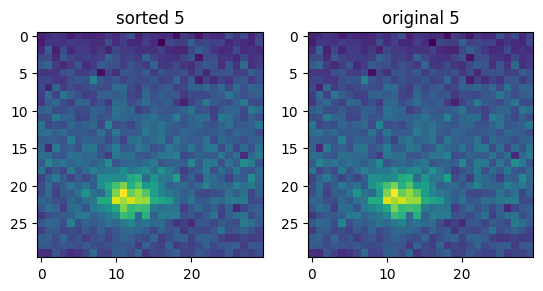

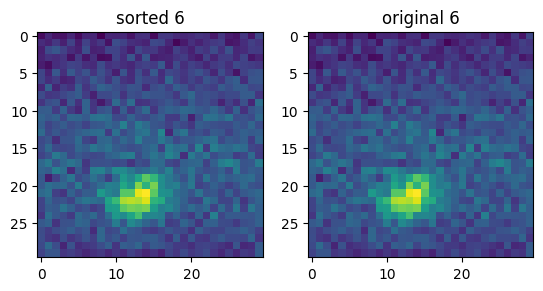

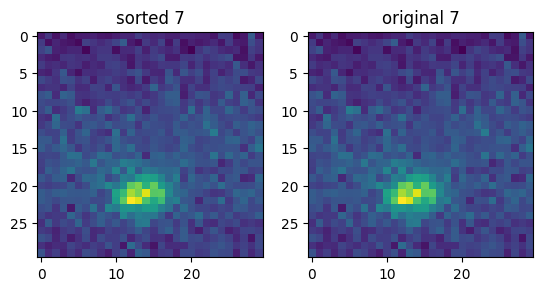

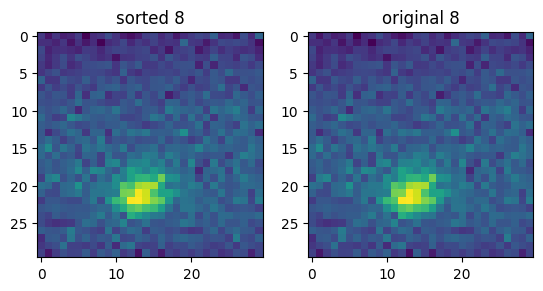

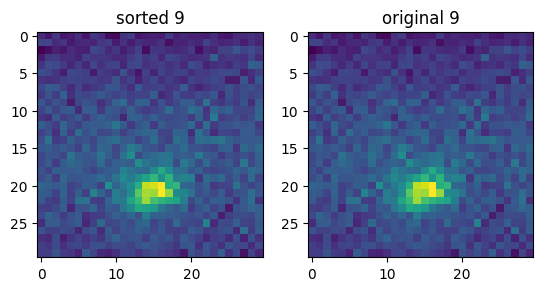

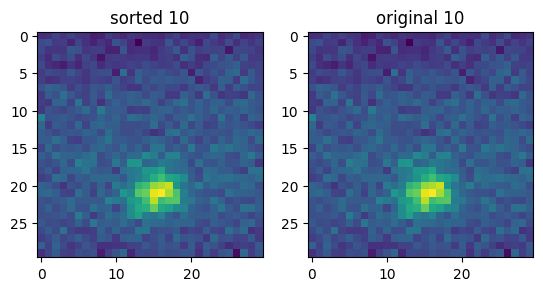

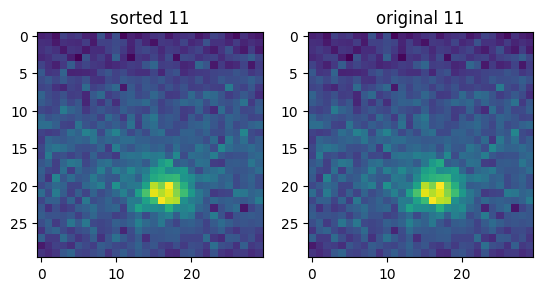

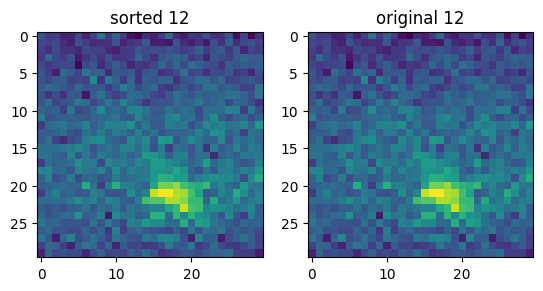

In [315]:
# check that we understand how the data was sorted
for i in range(steps):
    fig,(ax,ax2) = plt.subplots(ncols=2)
    ax.imshow(image_groups[0][0][i]) # zeroth index is group, first is iteration, second is step
    ax.set_title(f"sorted {i}")
    ax2.imshow(images[i,:,:])
    ax2.set_title(f"original {i}")
    plt.show()

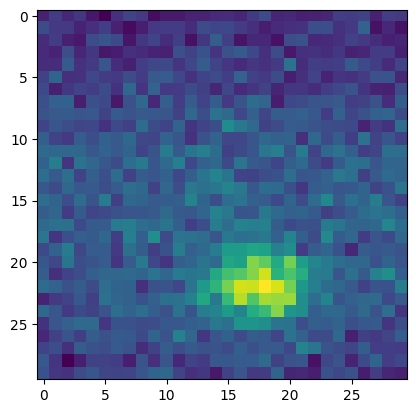

In [316]:
plt.imshow(image_groups[9][4,12]) # last group, last iteration in that group, and last step of the 13-point scan

In [317]:
mean_im_groups = [] # stores groups each containing steps number of images averaged over iterations/groups number of iterations
for i in range(groups):
    mean_ims_by_step = [np.mean(image_groups[i][:,j],axis=0) for j in range(steps)]
    mean_im_groups.append(mean_ims_by_step)

In [318]:
len(mean_im_groups[0])

13

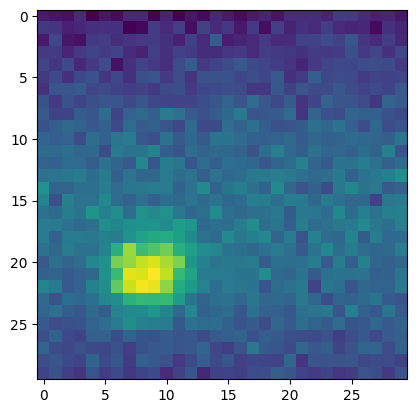

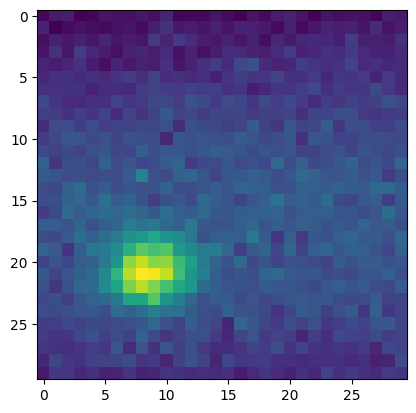

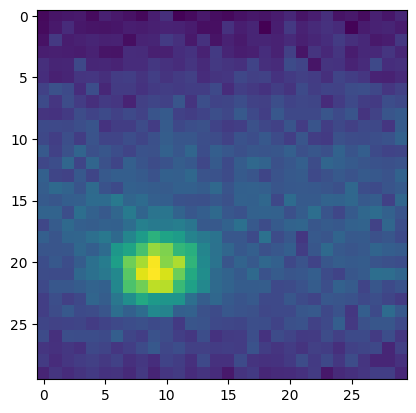

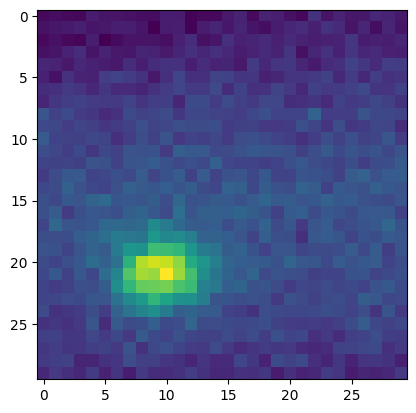

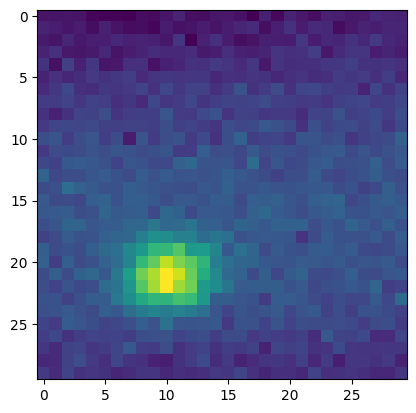

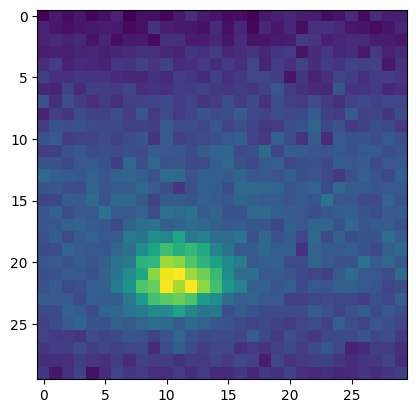

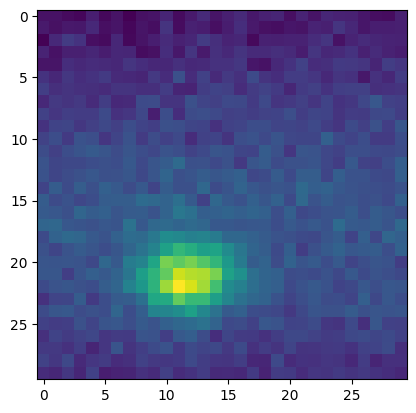

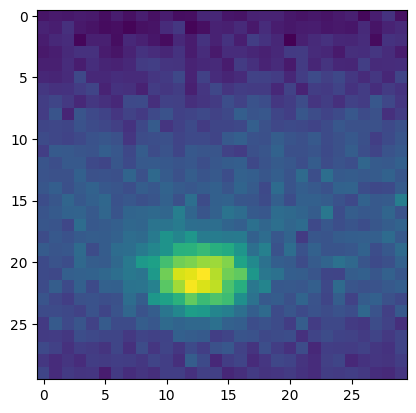

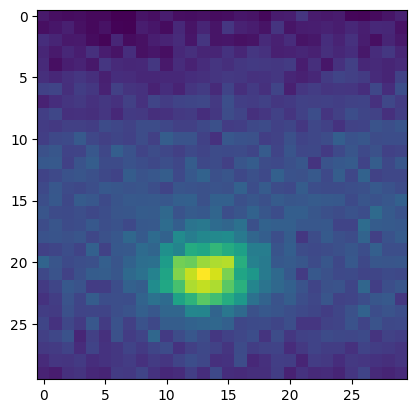

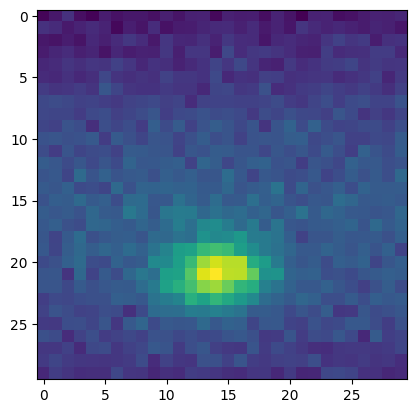

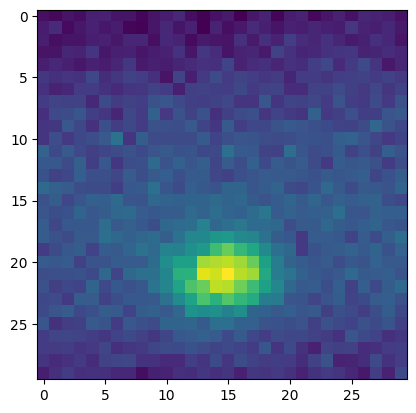

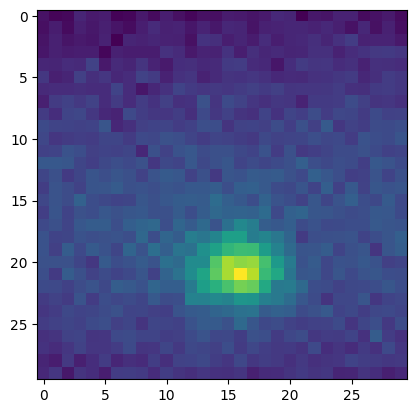

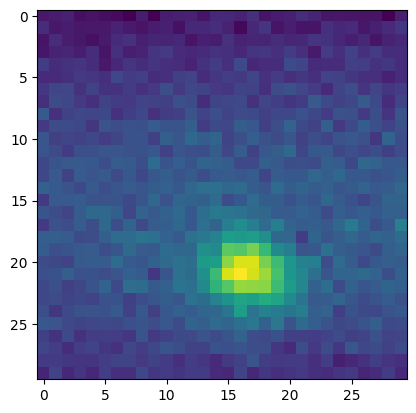

In [319]:
for im in mean_im_groups[0]:
    plt.imshow(im)
    plt.show()

In [320]:
showplots = False

def model(x, x0, w0, b):
            return np.exp(-2*((x-x0)/w0)**2) + b

x_groups = [] # store arrays of the x positions of the MOT for each group of averaged images
y_groups = [] # store arrays of the y positions of the MOT for each group of averaged images

for group in mean_im_groups:

    x_arr = np.zeros(steps)
    y_arr = np.zeros(steps)

    for i,im in enumerate(group):
        # generate projections, fits, etc

        bg = np.mean([im[12:17,25:30] for i in range(steps)])

        image = im
        image[image < bg] = bg
        image -= bg
        
        xproj = np.sum(image,axis=0)
        xproj /= max(xproj)
        yproj = np.sum(image,axis=1)
        yproj /= max(yproj)

        # mean, waist, offset
        x_guess = [12,5,0]
        y_guess = [19,4,0]
        upper_bounds = [30,20,1.1]
        lower_bounds = [0,3,-0.1]

        xpts = np.arange(im.shape[1])
        ypts = np.arange(im.shape[0])

        xparams, _ = curve_fit(model, xpts, xproj, p0=x_guess, 
                           bounds=[lower_bounds,upper_bounds])
            
        yparams, _ = curve_fit(model, ypts, yproj, p0=y_guess, 
                           bounds=[lower_bounds,upper_bounds])

        x_arr[i] = xparams[0]
        y_arr[i] = yparams[0]

        if showplots:
            plt.imshow(image)
            plt.title(f"image{i}")
            plt.show()
            plt.plot(xproj)
            plt.plot(model(xpts,*xparams))
            plt.plot(yproj)
            plt.plot(model(ypts,*yparams))
            plt.show()
    x_groups.append(x_arr)
    y_groups.append(y_arr)

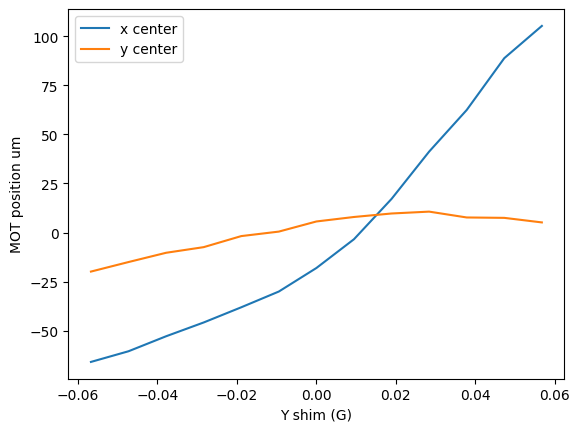

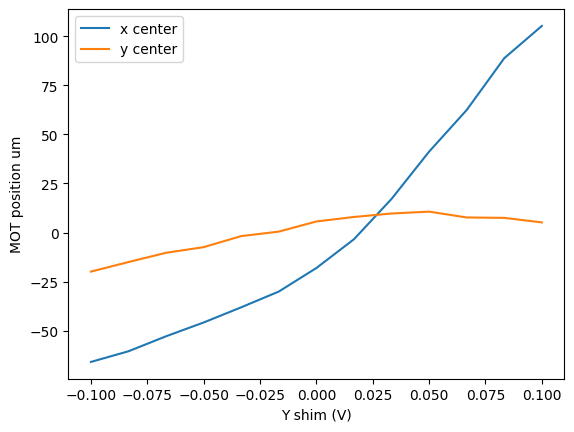

In [321]:
x_means = np.mean([x-np.mean(x) for x in x_groups],axis=0)
y_means = np.mean([y-np.mean(y) for y in y_groups],axis=0)

Bpts = y_shimsteps*0.25*2.27 # (Zotino V)*(coil driver A/V)*(measured coil G/A)

fig,ax = plt.subplots()
ax.plot(Bpts,x_means/pixels_per_um,label='x center')
ax.plot(Bpts,y_means/pixels_per_um,label='y center')
ax.set_ylabel('MOT position um')
ax.set_xlabel('Y shim (G)')
ax.legend()
plt.show()

fig,ax = plt.subplots()
ax.plot(y_shimsteps,x_means/pixels_per_um,label='x center')
ax.plot(y_shimsteps,y_means/pixels_per_um,label='y center')
ax.set_ylabel('MOT position um')
ax.set_xlabel('Y shim (V)')
ax.legend()
plt.show()

# for x,y in zip(x_groups,y_groups):
#     plt.plot(x-np.mean(x),label='x center')
#     plt.plot(y-np.mean(y),label='y center')
#     plt.legend()
#     plt.show()

In [308]:
print("microns per mG",160/120)
print("microns per mV",160/200)

microns per mG 1.3333333333333333
microns per mV 0.8


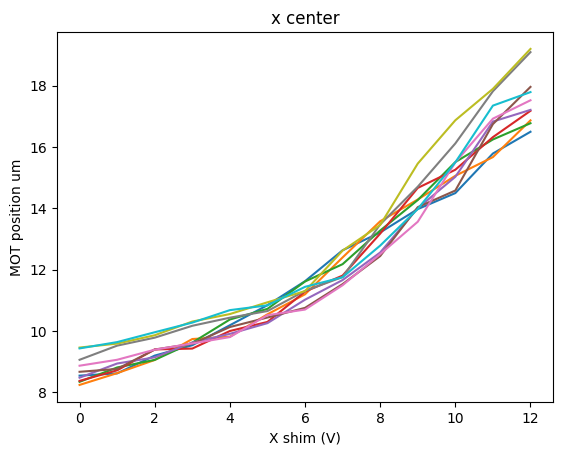

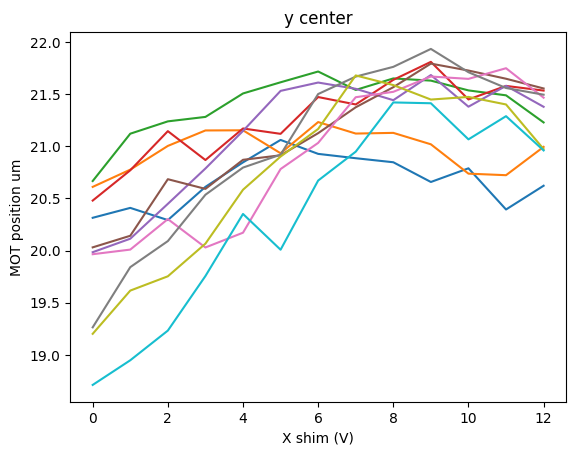

In [322]:
fig,ax = plt.subplots()
for x in x_groups:
    plt.plot(x) #,label='x center')
ax.set_ylabel('MOT position um')
ax.set_xlabel('X shim (V)')
ax.set_title('x center')
plt.show()

fig,ax = plt.subplots()
for y in y_groups:
    plt.plot(y)
ax.set_ylabel('MOT position um')
ax.set_xlabel('X shim (V)')
ax.set_title('y center')
plt.show()